# Notebook containing examples on how to train the model

Probabilistic Residual Neural Network (based on Student's T distribution and MC dropout)

In [1]:
%reload_ext autoreload
%autoreload 3
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent / 'src'))
from forecastpnn.utils.data_functions import get_dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from sklearn.model_selection import train_test_split as TTS
import torch
import random
import numpy as np
torch.use_deterministic_algorithms(True) # reproducibility
import pandas as pd

from forecastpnn.utils.train_utils import SubsetSampler as SS
from forecastpnn.utils.constants import RANDOM_SEED

WEEKS = True
PAST_UNITS = 12
BATCH_SIZE = 64
RANDOM_SPLIT = False
DEVICE = "mps"

data = pd.read_csv('../data/derived/DENGSP.csv')
dl = get_dataset(data, 'DT_SIN_PRI', weeks_in=False, weeks_out=WEEKS, past_units=PAST_UNITS, return_df=False, filter_year_min=2013, filter_year_max=2020)

#n_obs_40pu = len(dataset) # 2922 total dates, -39-39 for past_units and max_delay ->2844
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dl.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dl.__len__())
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
    else: 
        train_idcs, test_idcs = range(int(0.75*dl.__len__())), range(int(0.75*dl.__len__()), dl.__len__()) # 2844 total obs - 711 test, still 25% even without random split, last outbreak 2353
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(RANDOM_SEED)
train_sampler, val_sampler, test_sampler = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader, val_loader, test_loader = DataLoader(dl, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dl, batch_size=VAL_BATCH_SIZE, sampler=val_sampler, shuffle=False), DataLoader(dl, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(RANDOM_SEED)
    global train_loader
    train_loader = DataLoader(dl, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(RANDOM_SEED)

/var/folders/xr/mqd4g8995xqfhcvcyvr2smdc0000gn/T/ipykernel_1320/933801931.py:26: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/derived/DENGSP.csv')
2024-12-15 13:47:11.369 | WARNING  | forecastpnn.utils.data_functions:get_dataset:228 - If output data is indexed by weeks, day of the weeks cannot be used as feature, so keyword dow will be ignored.


reloaded


In [60]:
from forecastpnn.utils.train_utils import train, EarlyStopper
from forecastpnn.models.forecastpnn import ForecastPNN
set_seeds(RANDOM_SEED)

regen_data() # reset samplers so each training run is reproducible
early_stopper = EarlyStopper(patience=30, past_units=PAST_UNITS, weeks=WEEKS, future_obs=0)
forecast_pnn = ForecastPNN(past_units=PAST_UNITS)
#forecast_pnn = PNNSumDaily(past_units=PAST_UNITS, max_delay=MAX_DELAY)  # "mse_real"
train(nowcast_pnn, num_epochs=500, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = DEVICE)
## Load best set of weights on test/validation set
forecast_pnn.load_state_dict(torch.load(f".weights/weights-{PAST_UNITS}-{'week' if WEEKS else 'day'}{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if False else ''}"))

Epoch 1 - Train loss: 9.75e+02 - Val loss: 1.33e+03 - ES count: 0
Epoch 2 - Train loss: 9.85e+02 - Val loss: 1.33e+03 - ES count: 0
Epoch 3 - Train loss: 9.62e+02 - Val loss: 1.32e+03 - ES count: 0
Epoch 4 - Train loss: 9.33e+02 - Val loss: 1.32e+03 - ES count: 0
Epoch 5 - Train loss: 9.51e+02 - Val loss: 1.32e+03 - ES count: 0
Epoch 6 - Train loss: 9.42e+02 - Val loss: 1.31e+03 - ES count: 0
Epoch 7 - Train loss: 9.36e+02 - Val loss: 1.31e+03 - ES count: 0
Epoch 8 - Train loss: 9.22e+02 - Val loss: 1.3e+03 - ES count: 0
Epoch 9 - Train loss: 9.04e+02 - Val loss: 1.29e+03 - ES count: 0
Epoch 10 - Train loss: 9.12e+02 - Val loss: 1.29e+03 - ES count: 0
Epoch 11 - Train loss: 8.97e+02 - Val loss: 1.29e+03 - ES count: 0
Epoch 12 - Train loss: 9.11e+02 - Val loss: 1.28e+03 - ES count: 0
Epoch 13 - Train loss: 9.01e+02 - Val loss: 1.28e+03 - ES count: 0
Epoch 14 - Train loss: 8.83e+02 - Val loss: 1.27e+03 - ES count: 0
Epoch 15 - Train loss: 8.69e+02 - Val loss: 1.27e+03 - ES count: 1
Epoch

/var/folders/xr/mqd4g8995xqfhcvcyvr2smdc0000gn/T/ipykernel_1320/2542529488.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nowcast_pnn.load_state_dict(torch.load(f".wei

<All keys matched successfully>

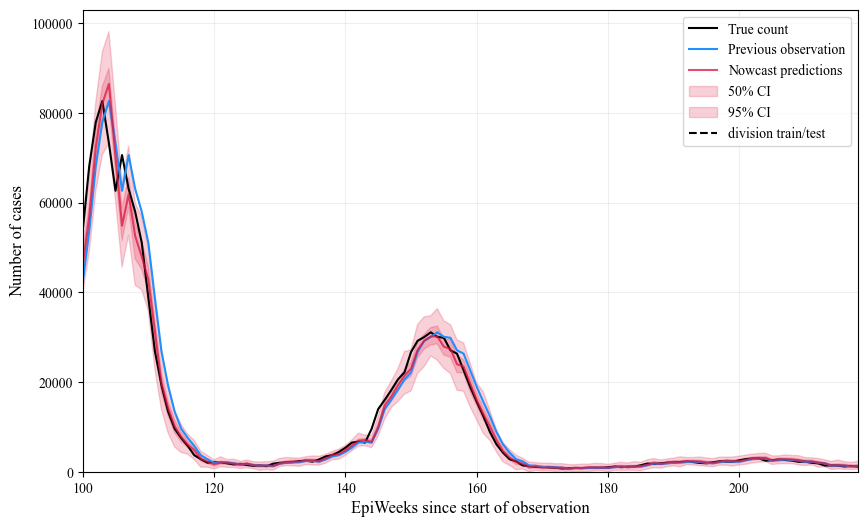

In [ ]:
from forecastpnn.utils.plotting import plot_entire_confints

set_seeds(RANDOM_SEED)
plot_entire_confints(dl, forecast_pnn, weeks = WEEKS, random_split = RANDOM_SPLIT, test_idcs=test_idcs, total = False, xlims=[100, 218])


## Daily data

In [70]:
%reload_ext autoreload
%autoreload 3
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent / 'src'))
from forecastpnn.utils.data_functions import get_dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from sklearn.model_selection import train_test_split as TTS
import torch
import random
import numpy as np
torch.use_deterministic_algorithms(True) # reproducibility
import pandas as pd

from forecastpnn.utils.train_utils import SubsetSampler as SS
from forecastpnn.utils.constants import RANDOM_SEED

WEEKS = False
PAST_UNITS = 30
BATCH_SIZE = 64
RANDOM_SPLIT = False
DEVICE = "mps"

data = pd.read_csv('../data/derived/DENGSP.csv')
dl = get_dataset(data, 'DT_SIN_PRI', weeks_in=False, weeks_out=WEEKS, past_units=PAST_UNITS, return_df=False, filter_year_min=2013, filter_year_max=2020, dow=False)

#n_obs_40pu = len(dataset) # 2922 total dates, -39-39 for past_units and max_delay ->2844
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dl.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dl.__len__())
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
    else: 
        train_idcs, test_idcs = range(int(0.75*dl.__len__())), range(int(0.75*dl.__len__()), dl.__len__()) # 2844 total obs - 711 test, still 25% even without random split, last outbreak 2353
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(RANDOM_SEED)
train_sampler, val_sampler, test_sampler = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader, val_loader, test_loader = DataLoader(dl, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dl, batch_size=VAL_BATCH_SIZE, sampler=val_sampler, shuffle=False), DataLoader(dl, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(RANDOM_SEED)
    global train_loader
    train_loader = DataLoader(dl, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(RANDOM_SEED)

/var/folders/xr/mqd4g8995xqfhcvcyvr2smdc0000gn/T/ipykernel_1320/2011283049.py:26: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/derived/DENGSP.csv')


reloaded


In [127]:
from forecastpnn.utils.train_utils import train, EarlyStopper
from forecastpnn.models.forecastpnn import ForecastPNN, ForecastPNNDay
set_seeds(RANDOM_SEED)

regen_data() # reset samplers so each training run is reproducible
early_stopper = EarlyStopper(patience=30, past_units=PAST_UNITS, weeks=WEEKS, future_obs=0)
forecast_pnn = ForecastPNNDay(past_units=PAST_UNITS, hidden_units=[24, 48, 24])
#forecast_pnn = PNNSumDaily(past_units=PAST_UNITS, max_delay=MAX_DELAY)  # "mse_real"
train(forecast_pnn, num_epochs=500, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = DEVICE)
## Load best set of weights on test/validation set
forecast_pnn.load_state_dict(torch.load(f".weights/weights-{PAST_UNITS}-{'week' if WEEKS else 'day'}{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if False else ''}"))

Epoch 1 - Train loss: 5.93e+02 - Val loss: 4.52e+03 - ES count: 0
Epoch 2 - Train loss: 5.33e+02 - Val loss: 4.25e+03 - ES count: 0
Epoch 3 - Train loss: 5.16e+02 - Val loss: 4.11e+03 - ES count: 0
Epoch 4 - Train loss: 5.01e+02 - Val loss: 4.07e+03 - ES count: 0
Epoch 5 - Train loss: 4.99e+02 - Val loss: 4.08e+03 - ES count: 1
Epoch 6 - Train loss: 4.95e+02 - Val loss: 4.06e+03 - ES count: 0
Epoch 7 - Train loss: 4.91e+02 - Val loss: 4.05e+03 - ES count: 0
Epoch 8 - Train loss: 4.86e+02 - Val loss: 4.04e+03 - ES count: 0
Epoch 9 - Train loss: 4.85e+02 - Val loss: 4.04e+03 - ES count: 0
Epoch 10 - Train loss: 4.82e+02 - Val loss: 4.03e+03 - ES count: 0
Epoch 11 - Train loss: 4.8e+02 - Val loss: 4.02e+03 - ES count: 0
Epoch 12 - Train loss: 4.76e+02 - Val loss: 4.02e+03 - ES count: 0
Epoch 13 - Train loss: 4.75e+02 - Val loss: 4.01e+03 - ES count: 0
Epoch 14 - Train loss: 4.74e+02 - Val loss: 4.01e+03 - ES count: 0
Epoch 15 - Train loss: 4.72e+02 - Val loss: 4e+03 - ES count: 0
Epoch 16

/var/folders/xr/mqd4g8995xqfhcvcyvr2smdc0000gn/T/ipykernel_1320/944136274.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forecast_pnn.load_state_dict(torch.load(f".wei

<All keys matched successfully>

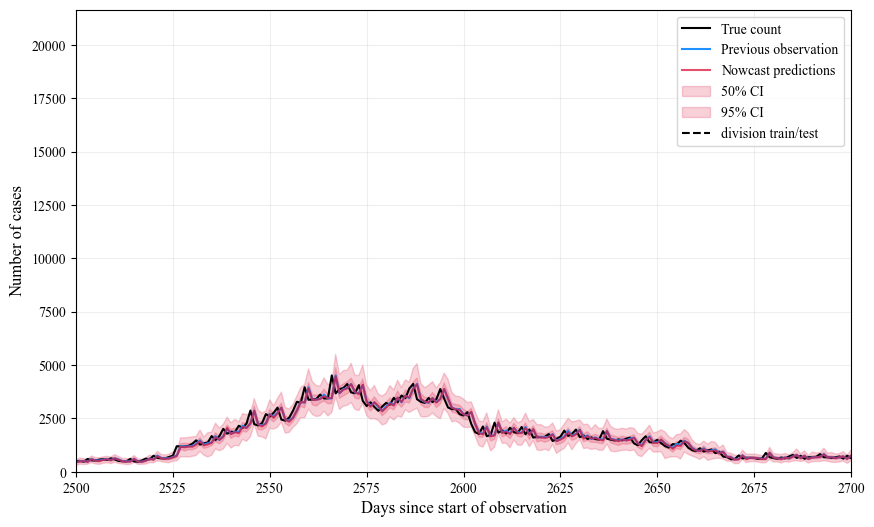

In [128]:
from forecastpnn.utils.plotting import plot_entire_confints

set_seeds(RANDOM_SEED)
plot_entire_confints(dl, forecast_pnn, weeks = WEEKS, random_split = RANDOM_SPLIT, test_idcs=test_idcs, xlims=[2500, 2700])


In [129]:
from forecastpnn.utils.metrics import pnn_PIs_indiv, evaluate_PIs
set_seeds(RANDOM_SEED)
## Write function to generate interval dict, and safe it if desired, then pass to standard evaluate_PI
levels_pnn = pnn_PIs_indiv(forecast_pnn, test_loader, random_split = RANDOM_SPLIT, save=False, future_obs=0) # can save if good scores and architecture to use for comparisons with others
_ = evaluate_PIs(levels_pnn, test_loader, return_coverages=False, return_is_decomposed=False, total = False)


Actual coverage per level | 5%: 3.6 | 10%: 5.81 | 25%: 16.6 | 50%: 36.1 | 75%: 57.54 | 90%: 81.47 | 95%: 93.5 |
PICA: 0.079
WIS: 185.14
IS: under = 135.77 | spread = 342.17 | over = 100.4 | total = 578.34


In [101]:
inputlayer = torch.zeros((BATCH_SIZE, PAST_UNITS, 5))
lstmlayer = torch.nn.LSTM(input_size=5, hidden_size=24, num_layers=1, batch_first=True)
output, (hn, cn) = lstmlayer(inputlayer)
print(output, output.shape)
# Flatten the LSTM output
flattened_output = output.contiguous().view(BATCH_SIZE, -1)

# Define fully connected layers to transform the flattened output
fc1 = torch.nn.Linear(PAST_UNITS * 24, 48)
fc2 = torch.nn.Linear(48, 24)
fc_mu = torch.nn.Linear(24, 1)
fc_sigma = torch.nn.Linear(24, 1)

# Apply the fully connected layers
x = torch.relu(fc1(flattened_output))
x = torch.relu(fc2(x))

# Calculate mu and sigma
mu = fc_mu(x)
sigma = torch.exp(fc_sigma(x))  # Ensure sigma is positive

# Concatenate mu and sigma to get the final output
final_output = torch.cat((mu, sigma), dim=1)
print(final_output, final_output.shape)

tensor([[[-0.0285, -0.0121,  0.0600,  ...,  0.0657, -0.0289,  0.0145],
         [-0.0475, -0.0216,  0.0880,  ...,  0.0965, -0.0467,  0.0224],
         [-0.0598, -0.0284,  0.1003,  ...,  0.1101, -0.0578,  0.0261],
         ...,
         [-0.0777, -0.0430,  0.1048,  ...,  0.1233, -0.0732,  0.0260],
         [-0.0777, -0.0430,  0.1048,  ...,  0.1233, -0.0732,  0.0260],
         [-0.0777, -0.0430,  0.1048,  ...,  0.1233, -0.0732,  0.0260]],

        [[-0.0285, -0.0121,  0.0600,  ...,  0.0657, -0.0289,  0.0145],
         [-0.0475, -0.0216,  0.0880,  ...,  0.0965, -0.0467,  0.0224],
         [-0.0598, -0.0284,  0.1003,  ...,  0.1101, -0.0578,  0.0261],
         ...,
         [-0.0777, -0.0430,  0.1048,  ...,  0.1233, -0.0732,  0.0260],
         [-0.0777, -0.0430,  0.1048,  ...,  0.1233, -0.0732,  0.0260],
         [-0.0777, -0.0430,  0.1048,  ...,  0.1233, -0.0732,  0.0260]],

        [[-0.0285, -0.0121,  0.0600,  ...,  0.0657, -0.0289,  0.0145],
         [-0.0475, -0.0216,  0.0880,  ...,  0

# Multi-feature model

In [1]:
%reload_ext autoreload
%autoreload 3
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent / 'src'))
from forecastpnn.utils.data_functions import get_dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from sklearn.model_selection import train_test_split as TTS
import torch
import random
import numpy as np
torch.use_deterministic_algorithms(True) # reproducibility
import pandas as pd

from forecastpnn.utils.train_utils import SubsetSampler as SS
from forecastpnn.utils.constants import RANDOM_SEED

WEEKS = False
PAST_UNITS = 30
BATCH_SIZE = 64
RANDOM_SPLIT = False
DEVICE = "mps"

data = pd.read_csv('../data/derived/DENGSP.csv')
daily_df = get_dataset(data, 'DT_SIN_PRI', weeks_in=False, weeks_out=WEEKS, past_units=PAST_UNITS, return_df=True, filter_year_min=2013, filter_year_max=2020, dow=False)
dl = get_dataset(data, 'DT_SIN_PRI', weeks_in=False, weeks_out=WEEKS, time_features=True, past_units=PAST_UNITS, return_df=False, filter_year_min=2013, filter_year_max=2020)

#n_obs_40pu = len(dataset) # 2922 total dates, -39-39 for past_units and max_delay ->2844
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dl.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dl.__len__())
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
    else: 
        train_idcs, test_idcs = range(int(0.75*dl.__len__())), range(int(0.75*dl.__len__()), dl.__len__()) # 2844 total obs - 711 test, still 25% even without random split, last outbreak 2353
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(RANDOM_SEED)
train_sampler, val_sampler, test_sampler = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader, val_loader, test_loader = DataLoader(dl, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dl, batch_size=VAL_BATCH_SIZE, sampler=val_sampler, shuffle=False), DataLoader(dl, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(RANDOM_SEED)
    global train_loader
    train_loader = DataLoader(dl, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(RANDOM_SEED)

/var/folders/xr/mqd4g8995xqfhcvcyvr2smdc0000gn/T/ipykernel_20358/4284103496.py:26: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/derived/DENGSP.csv')


In [170]:
from forecastpnn.utils.train_utils import train, EarlyStopper
from forecastpnn.models.forecastpnn import ForecastPNNDayMultiFeature
set_seeds(RANDOM_SEED)

regen_data() # reset samplers so each training run is reproducible
early_stopper = EarlyStopper(patience=30, past_units=PAST_UNITS, weeks=WEEKS, future_obs=0)
forecast_pnn = ForecastPNNDayMultiFeature(past_units=PAST_UNITS, hidden_units=[64, 32, 16], n_features=5, hidden_size=128)
#forecast_pnn = PNNSumDaily(past_units=PAST_UNITS, max_delay=MAX_DELAY)  # "mse_real"
train(forecast_pnn, num_epochs=500, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = DEVICE)
## Load best set of weights on test/validation set
forecast_pnn.load_state_dict(torch.load(f".weights/weights-{PAST_UNITS}-{'week' if WEEKS else 'day'}{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if False else ''}"))

Epoch 1 - Train loss: 2.95e+05 - Val loss: 3.19e+06 - ES count: 0
Epoch 2 - Train loss: 2.36e+05 - Val loss: 3.02e+06 - ES count: 0
Epoch 3 - Train loss: 1.9e+05 - Val loss: 2.45e+06 - ES count: 0
Epoch 4 - Train loss: 1.47e+05 - Val loss: 1.25e+06 - ES count: 0
Epoch 5 - Train loss: 1.13e+05 - Val loss: 7.92e+05 - ES count: 0
Epoch 6 - Train loss: 9.12e+04 - Val loss: 8.22e+05 - ES count: 1
Epoch 7 - Train loss: 7.04e+04 - Val loss: 4.89e+05 - ES count: 0
Epoch 8 - Train loss: 5.67e+04 - Val loss: 4.13e+05 - ES count: 0
Epoch 9 - Train loss: 4.58e+04 - Val loss: 2.43e+05 - ES count: 0
Epoch 10 - Train loss: 3.75e+04 - Val loss: 2.01e+05 - ES count: 0
Epoch 11 - Train loss: 3.56e+04 - Val loss: 2.35e+05 - ES count: 1
Epoch 12 - Train loss: 3.03e+04 - Val loss: 2.28e+05 - ES count: 2
Epoch 13 - Train loss: 2.46e+04 - Val loss: 2.29e+05 - ES count: 3
Epoch 14 - Train loss: 2.28e+04 - Val loss: 1.4e+05 - ES count: 0
Epoch 15 - Train loss: 2.12e+04 - Val loss: 9.78e+04 - ES count: 0
Epoch 

/var/folders/xr/mqd4g8995xqfhcvcyvr2smdc0000gn/T/ipykernel_1320/4163970333.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forecast_pnn.load_state_dict(torch.load(f".we

<All keys matched successfully>

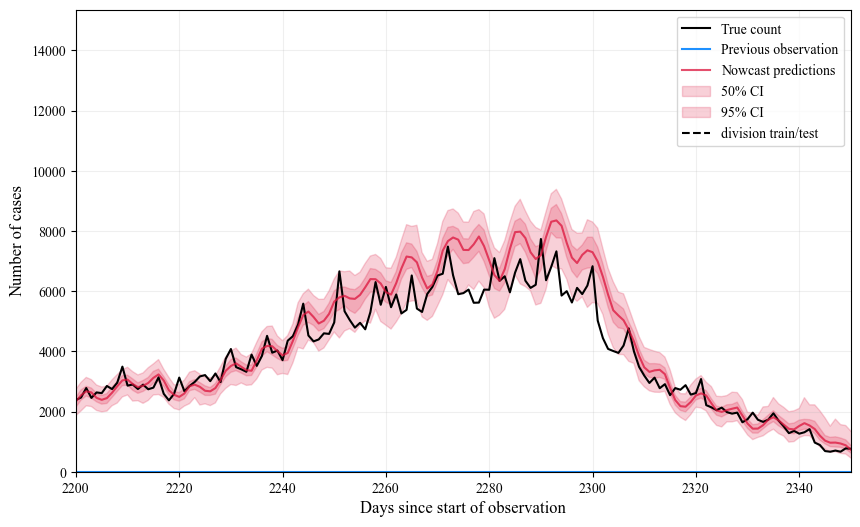

In [173]:
from forecastpnn.utils.plotting import plot_entire_confints

set_seeds(RANDOM_SEED)
plot_entire_confints(dl, forecast_pnn, weeks = WEEKS, random_split = RANDOM_SPLIT, test_idcs=test_idcs, xlims=[2200, 2350])


In [172]:
from forecastpnn.utils.metrics import pnn_PIs_indiv, evaluate_PIs
set_seeds(RANDOM_SEED)
## Write function to generate interval dict, and safe it if desired, then pass to standard evaluate_PI
levels_pnn = pnn_PIs_indiv(forecast_pnn, test_loader, random_split = RANDOM_SPLIT, save=False, future_obs=0) # can save if good scores and architecture to use for comparisons with others
_ = evaluate_PIs(levels_pnn, test_loader, return_coverages=False, return_is_decomposed=False, total = False)


Actual coverage per level | 5%: 1.52 | 10%: 3.6 | 25%: 9.13 | 50%: 22.54 | 75%: 73.31 | 90%: 94.88 | 95%: 98.06 |
PICA: 0.09
WIS: 318.21
IS: under = 279.07 | spread = 546.43 | over = 237.42 | total = 1062.92


## Multistep predictions

From certain start point, now predict several steps ahead. Always feed the next predicted model back into the model to predict the next step. For daily data, try with 14 and 30 days ahead.

In [211]:
# Select index, then get x forecast values, then plot
from forecastpnn.utils.pred_utils import create_multistep_forecasts_point
idx = 2275
forecasts, true_vals = create_multistep_forecasts_point(model=forecast_pnn, dataset=dl, idx=idx, steps= 50, return_true = True)

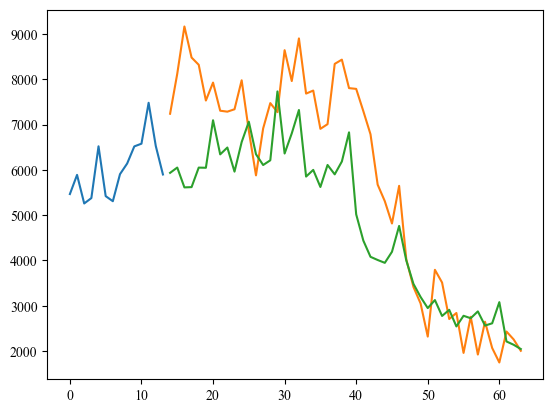

In [212]:
import matplotlib.pyplot as plt
steps_before = 14
prev_vals = [dl.__getitem__(i)[1].cpu().numpy() for i in range(idx-steps_before, idx)]
plt.plot(range(steps_before), prev_vals, label = 'Previous')
plt.plot(range(steps_before, steps_before + len(forecasts)), np.squeeze(forecasts), label = 'Forecast')
plt.plot(range(steps_before, steps_before + len(forecasts)), np.squeeze(true_vals), label = 'True')
plt.show()

Generating samples per forecast step: 100%|██████████| 31/31 [04:57<00:00,  9.60s/it]


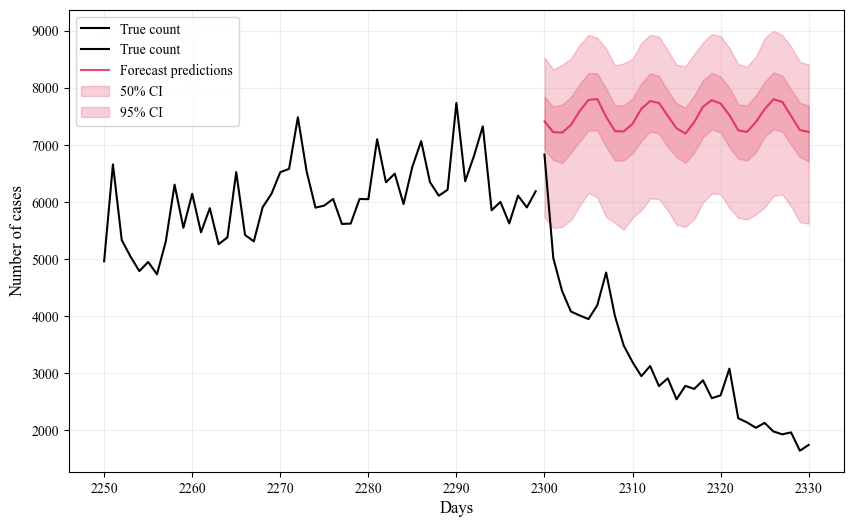

In [222]:
from forecastpnn.utils.plotting import plot_confints_forecast
plot_confints_forecast(dataset=dl, model=forecast_pnn, idx=2300, steps=31, steps_before=50)

# Investigate EM Algorithm to fit distribution to outbreak, sample from that

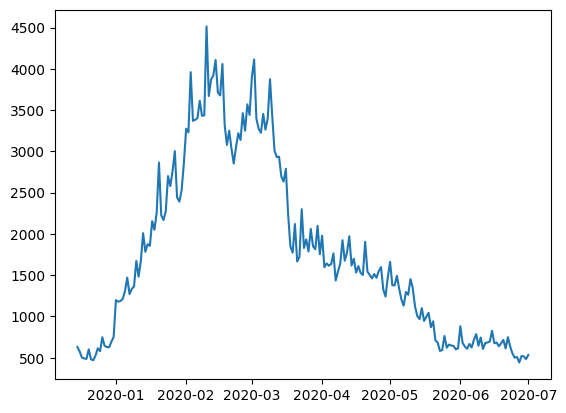

In [37]:
import matplotlib.pyplot as plt
bounds = [pd.date_range("2013-01-01", "2013-07-01"), pd.date_range("2014-02-01", "2014-07-01"), pd.date_range("2015-01-01", "2015-07-01"), pd.date_range("2015-11-01", "2016-07-01"), pd.date_range("2016-09-01", "2017-07-01"), pd.date_range("2017-08-01", "2018-08-01"), pd.date_range("2019-01-01", "2019-08-01"), pd.date_range("2019-12-15", "2020-07-01")]
plt.plot(daily_df.loc[pd.date_range("2019-12-15", "2020-07-01"), "count"])

In [69]:
import scipy
import tqdm
from scipy.stats import skewnorm

def nl_skewnormal(samples, params):
        alpha, mu, sigma = params
        # Add penalty for invalid parameter values
        if sigma <= 0:
            return np.inf
        return -np.sum(np.log(skewnorm.pdf(samples, alpha, mu, sigma) + 1e-10))

def em_algorithm_skewnormal(samples, n_tries=10):
    best_params = None
    best_nll = np.inf
    
    # Initial guesses based on data statistics
    sample_mean = np.mean(samples)
    sample_std = np.std(samples)
    
    # Parameter bounds
    bounds = [
        (-10, 10),  # alpha
        (sample_mean - 3*sample_std, sample_mean + 3*sample_std),  # mu
        (0.1*sample_std, 10*sample_std)  # sigma
    ]
    
    for _ in tqdm(range(n_tries)):
        # Random initial values within reasonable ranges
        x0 = [
            np.random.uniform(-5, 10),  # alpha
            np.random.normal(sample_mean, sample_std/2),  # mu
            np.random.uniform(sample_std/2, sample_std*2)  # sigma
        ]
        
        # Try different optimization methods
        for method in ['Nelder-Mead', 'BFGS', 'Powell']:
            #try:
            result = scipy.optimize.minimize(
                lambda x: nl_skewnormal(samples, x), 
                x0=x0,
                method=method,
                bounds=bounds if method == 'Powell' else None
            )
            
            if result.success and result.fun < best_nll:
                best_nll = result.fun
                best_params = result.x
            #except:
                #continue
                
    if best_params is None:
        raise RuntimeError("Optimization failed to find valid parameters")
        
    return best_params[1], abs(best_params[2]), best_params[0]  # mu, sigma, alpha

In [64]:
from scipy.stats import skewnorm
def print_true_outbreak_vs_fitted_values(samples, alpha, mu, sigma, density=True):
    num_samples = len(samples)
    samples_opt = skewnorm.rvs(alpha, mu, sigma, size=num_samples, random_state=42)

    # Create integer bins that cover both datasets
    min_val = int(min(min(samples), min(samples_opt)))
    max_val = int(np.ceil(max(max(samples), max(samples_opt))))
    bins = np.arange(min_val, max_val + 1)

    plt.figure(figsize=(10, 6))
    plt.hist(samples, bins=bins, alpha=0.5, label='Original Samples', density=density)
    plt.hist(samples_opt, bins=bins, alpha=0.5, label='Fitted Samples', density=density)
    plt.legend(loc='upper right')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Original vs Fitted Skew Normal Distribution')
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:33<02:18, 17.27s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 30%|███       | 3/10 [00:53<02:11, 18.83s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 60%|██████    | 6/10 [01:41<01:05, 16.49s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 70%|███████   | 7/10 [01:56<00:48, 16.03s/it]/Users/silaskoemen/Documents/Project

Optimized parameters: mu=73.09, sigma=36.84, alpha=0.50


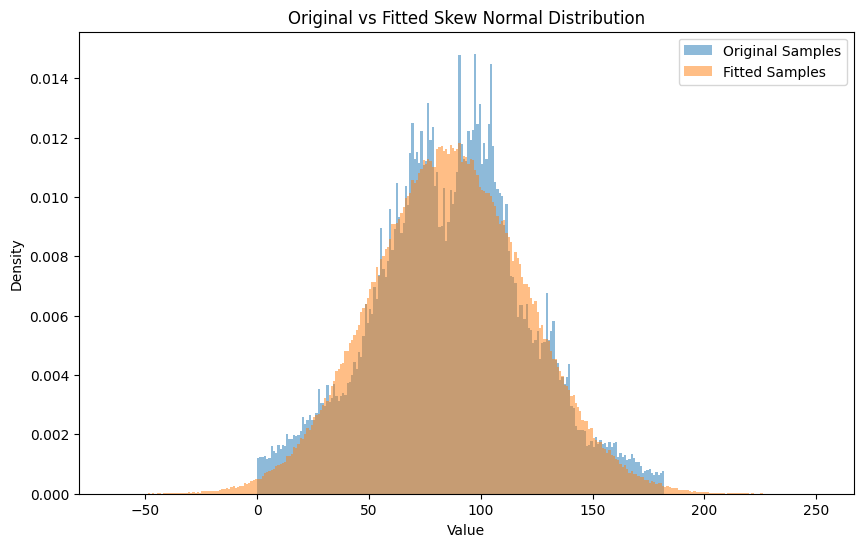

 40%|████      | 4/10 [00:58<01:30, 15.16s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 50%|█████     | 5/10 [01:16<01:20, 16.01s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 60%|██████    | 6/10 [01:28<00:58, 14.71s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [02:32<00:00, 15.25s/it]


Optimized parameters: mu=99.79, sigma=37.50, alpha=-1.11


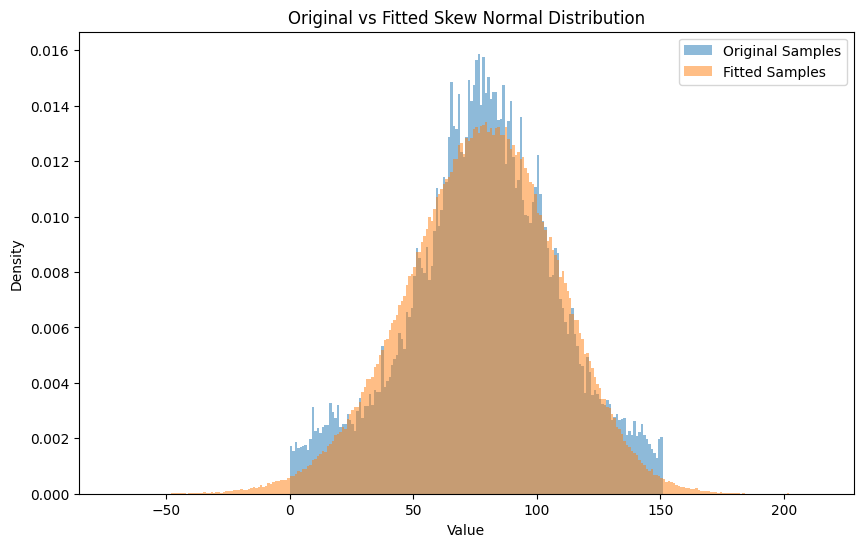

  0%|          | 0/10 [00:00<?, ?it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 40%|████      | 4/10 [03:02<04:35, 45.98s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 60%|██████    | 6/10 [04:44<03:11, 47.84s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 90%|█████████ | 9/10 [07:08<00:46, 46.09s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [07:56<00:00, 47.69s/

Optimized parameters: mu=62.91, sigma=39.68, alpha=0.84


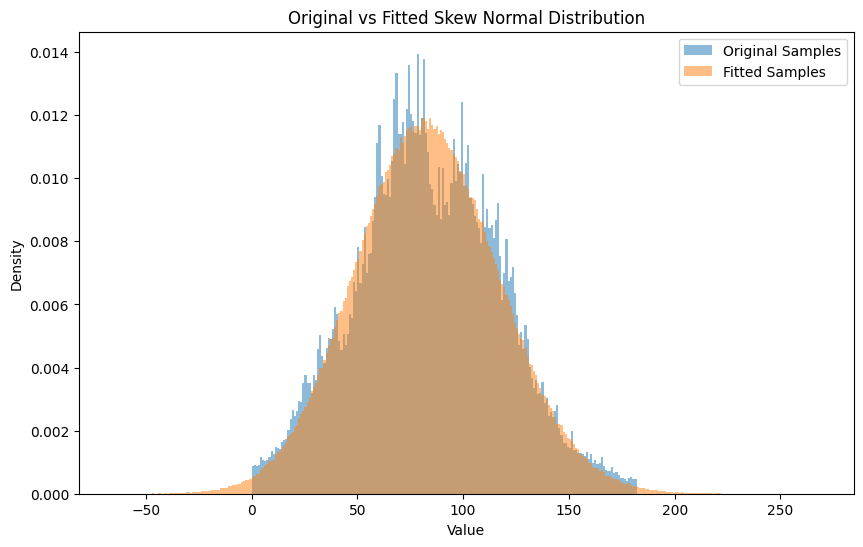

 20%|██        | 2/10 [01:01<04:00, 30.12s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 40%|████      | 4/10 [01:53<02:38, 26.35s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 50%|█████     | 5/10 [02:12<01:58, 23.65s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [04:17<00:00, 25.73s/it]


Optimized parameters: mu=154.30, sigma=56.65, alpha=-1.33


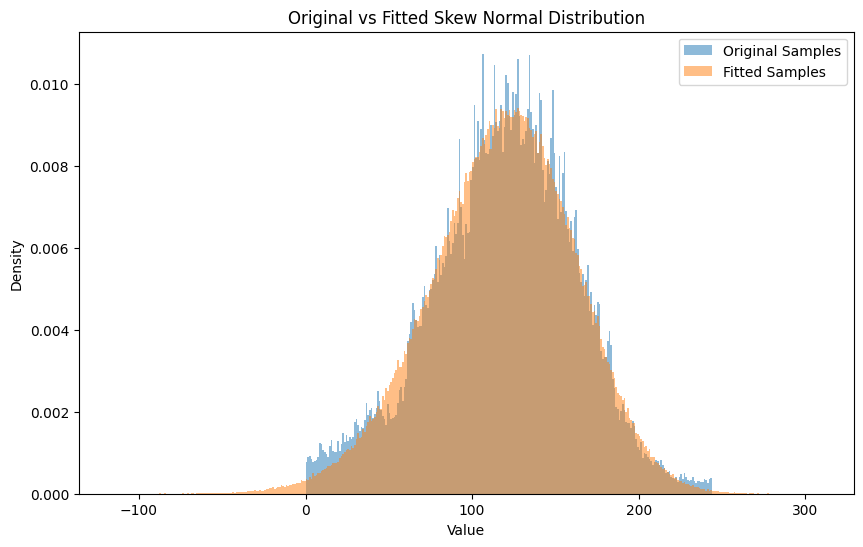

 10%|█         | 1/10 [00:03<00:31,  3.49s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 20%|██        | 2/10 [00:07<00:31,  3.98s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 40%|████      | 4/10 [00:16<00:24,  4.07s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 80%|████████  | 8/10 [00:29<00:07,  3.53s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [00:38<00:00,

Optimized parameters: mu=154.61, sigma=74.06, alpha=-0.10


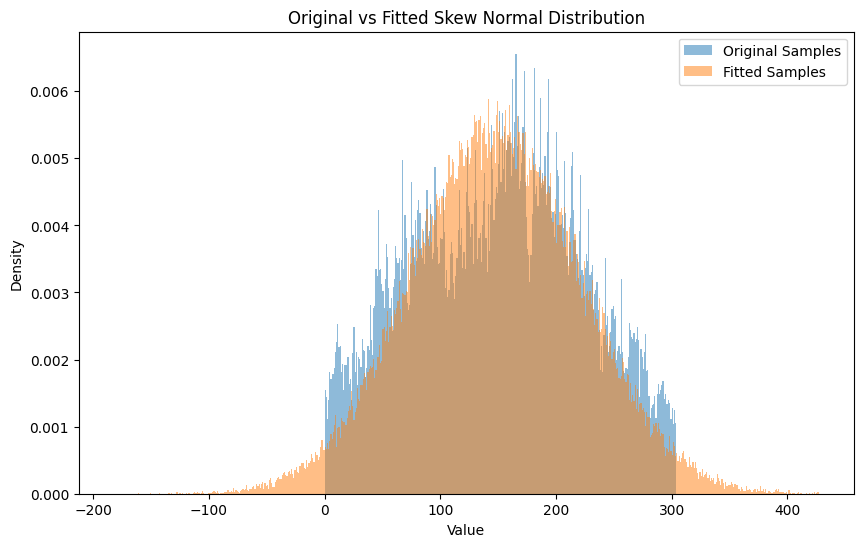

  0%|          | 0/10 [00:00<?, ?it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 70%|███████   | 7/10 [00:35<00:14,  4.92s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


Optimized parameters: mu=184.93, sigma=90.09, alpha=-0.07


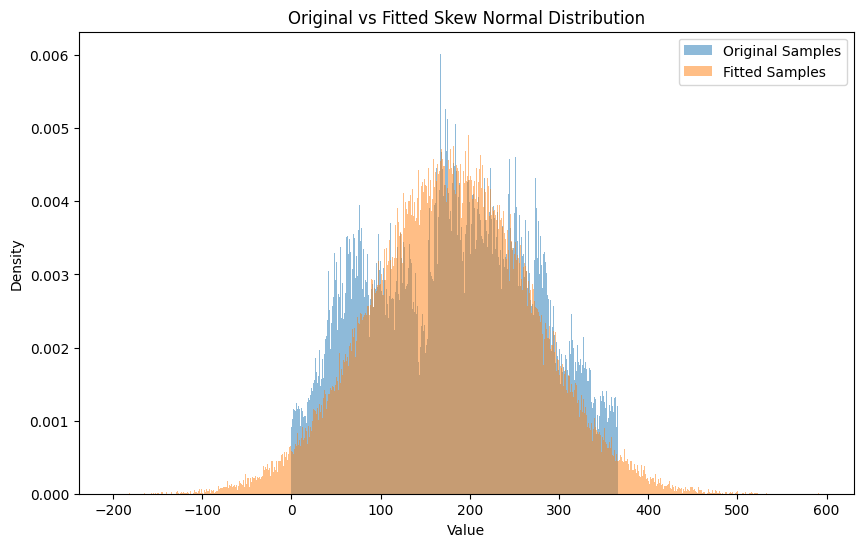

  0%|          | 0/10 [00:00<?, ?it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 70%|███████   | 7/10 [04:18<01:58, 39.41s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [05:57<00:00, 35.70s/it]


Optimized parameters: mu=139.38, sigma=55.43, alpha=-1.34


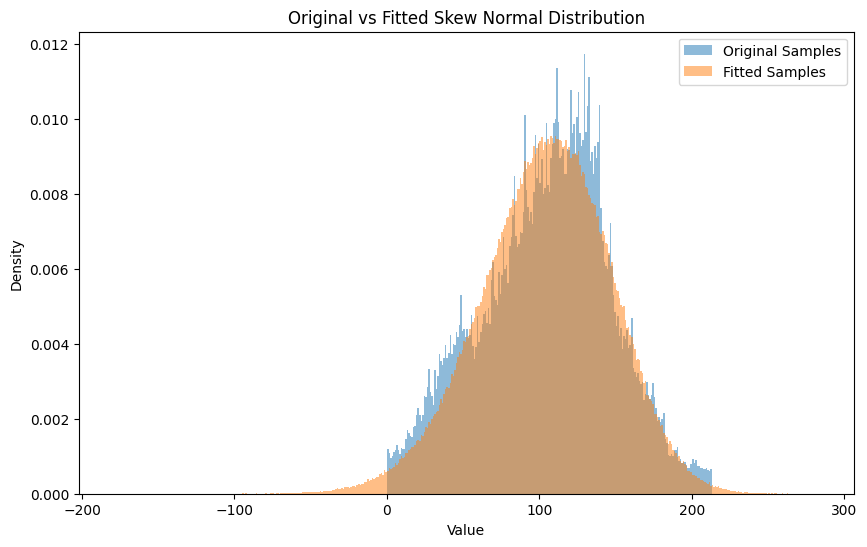

 70%|███████   | 7/10 [02:15<00:54, 18.32s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 80%|████████  | 8/10 [02:27<00:32, 16.41s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [03:07<00:00, 18.71s/it]


Optimized parameters: mu=30.98, sigma=69.60, alpha=3.65


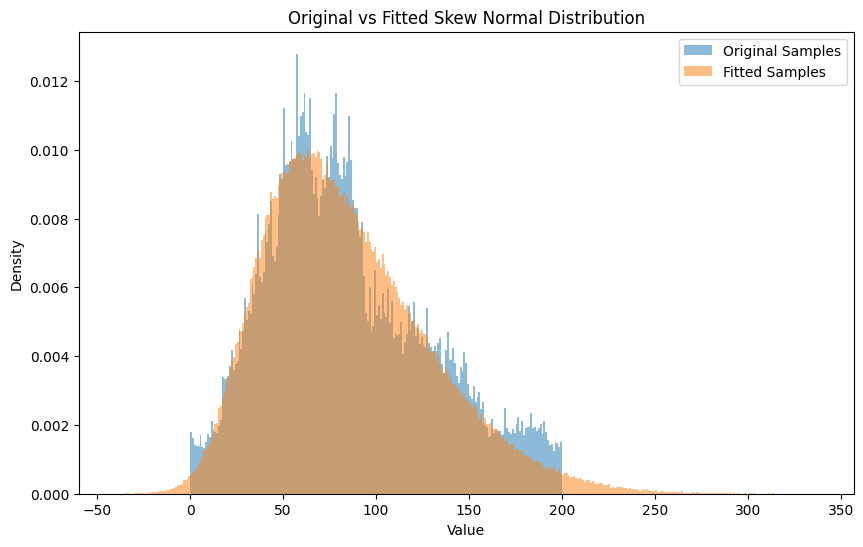

In [ ]:
import scipy
from tqdm import tqdm
from scipy.stats import skewnorm

for dr in bounds:
    samples = daily_df.loc[dr, "count"].values
    # Create array of repeated indices based on count values
    samples_array = np.repeat(np.arange(len(samples)), samples)
    mu, sigma, alpha = em_algorithm_skewnormal(samples_array, n_tries=10)
    #mu, sigma, alpha = em_algorithm_skewnormal(samples, n_tries=10)
    print(f"Optimized parameters: mu={mu:.2f}, sigma={sigma:.2f}, alpha={alpha:.2f}")
    print_true_outbreak_vs_fitted_values(samples_array, alpha, mu, sigma)


## Try with just the first 30 observations available, see if EM converges

In [67]:
from scipy.stats import skewnorm
def print_true_outbreak_vs_fitted_values_subs(samples, alpha, mu, sigma, samples_subs = None, density=True):
    num_samples = len(samples)
    samples_opt = skewnorm.rvs(alpha, mu, sigma, size=num_samples, random_state=42)

    # Create integer bins that cover both datasets
    min_val = int(min(min(samples), min(samples_opt)))
    max_val = int(np.ceil(max(max(samples), max(samples_opt))))
    bins = np.arange(min_val, max_val + 1)

    plt.figure(figsize=(10, 6))
    plt.hist(samples, bins=bins, alpha=0.5, label='Original Samples', density=density)
    plt.hist(samples_opt, bins=bins, alpha=0.5, label='Fitted Samples', density=density)
    if samples_subs is not None:
        plt.hist(samples_subs, bins=bins, alpha=0.5, label='Original Samples Subs', density=density)
    plt.legend(loc='upper right')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Original vs Fitted Skew Normal Distribution')
    plt.show()

 20%|██        | 2/10 [00:06<00:25,  3.13s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 30%|███       | 3/10 [00:09<00:23,  3.40s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 40%|████      | 4/10 [00:12<00:17,  2.96s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 70%|███████   | 7/10 [00:21<00:08,  2.89s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [00:30<00:00,

Optimized parameters: mu=48.96, sigma=22.34, alpha=-10.00


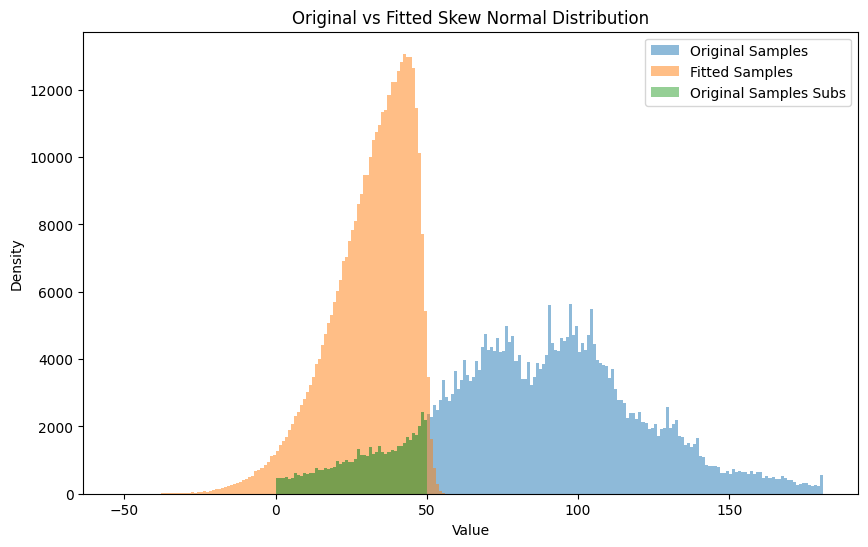

 10%|█         | 1/10 [00:04<00:39,  4.34s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 50%|█████     | 5/10 [00:16<00:15,  3.12s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 70%|███████   | 7/10 [00:22<00:08,  3.00s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


Optimized parameters: mu=49.15, sigma=23.04, alpha=-10.00


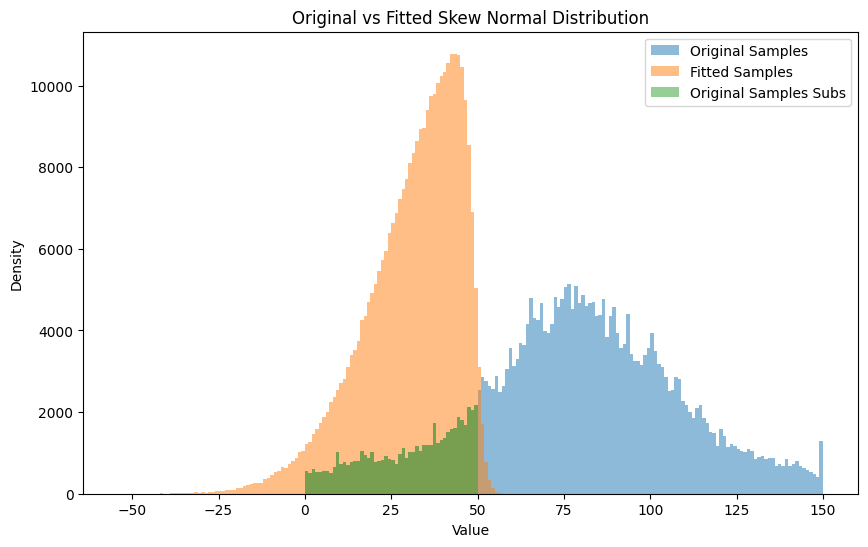

  0%|          | 0/10 [00:00<?, ?it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 10%|█         | 1/10 [00:10<01:30, 10.11s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 20%|██        | 2/10 [00:17<01:06,  8.26s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/

Optimized parameters: mu=48.73, sigma=20.48, alpha=-10.00


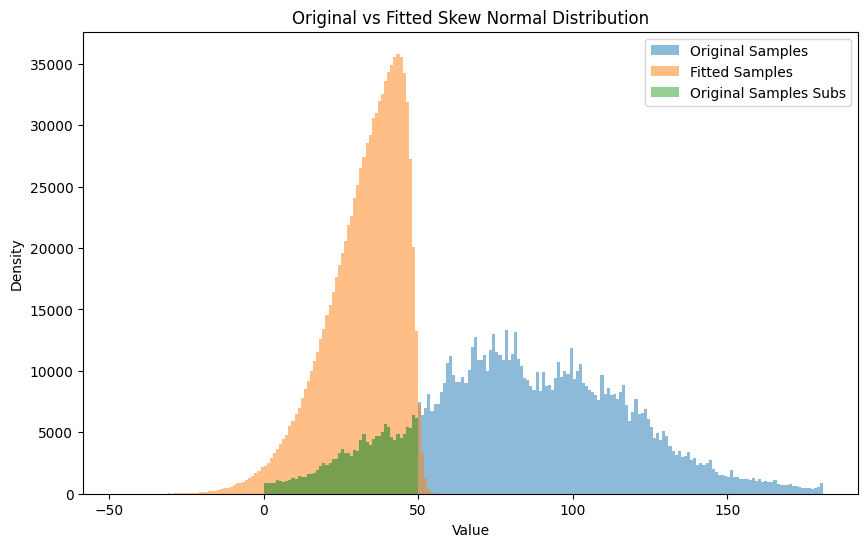

  0%|          | 0/10 [00:00<?, ?it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 50%|█████     | 5/10 [00:09<00:10,  2.03s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 80%|████████  | 8/10 [00:15<00:03,  1.73s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


Optimized parameters: mu=48.11, sigma=23.57, alpha=-10.00


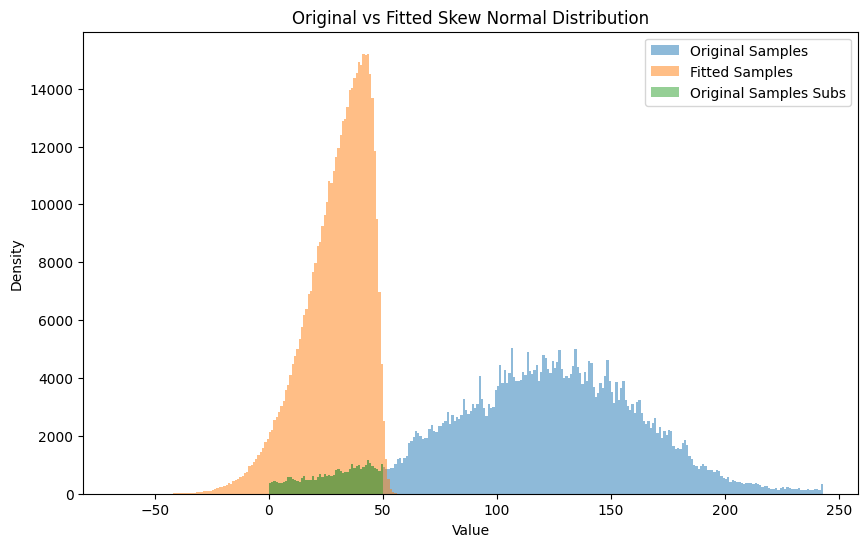

 10%|█         | 1/10 [00:00<00:04,  1.95it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 30%|███       | 3/10 [00:01<00:03,  1.84it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 90%|█████████ | 9/10 [00:05<00:00,  1.76it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Optimized parameters: mu=35.30, sigma=16.72, alpha=-0.75


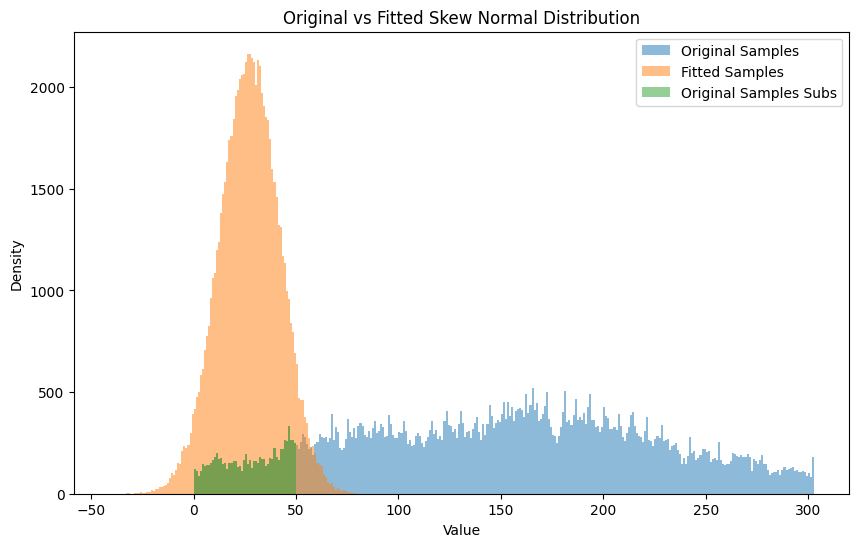

 20%|██        | 2/10 [00:00<00:03,  2.37it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 30%|███       | 3/10 [00:01<00:03,  2.26it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 40%|████      | 4/10 [00:01<00:02,  2.21it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 50%|█████     | 5/10 [00:02<00:02,  2.47it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 60%|██████    | 6/10 [00:02<00:01, 

Optimized parameters: mu=48.74, sigma=23.88, alpha=-10.00


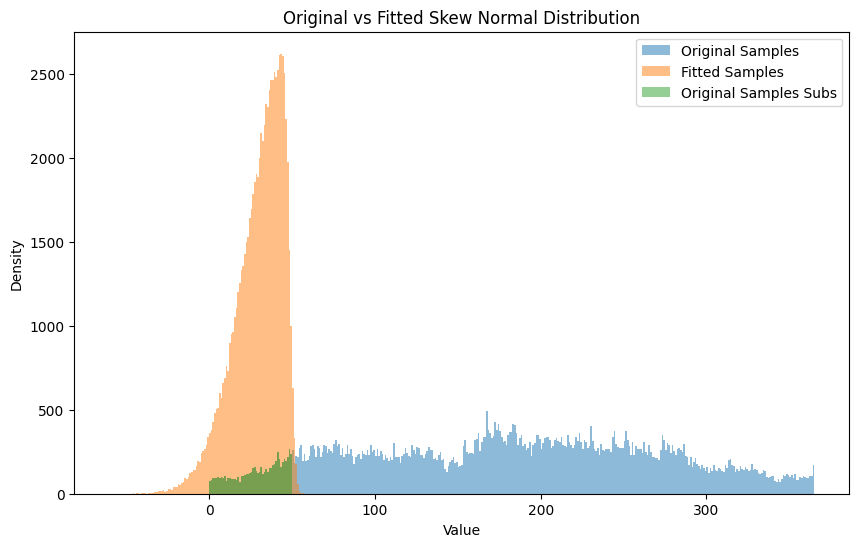

  0%|          | 0/10 [00:00<?, ?it/s]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 60%|██████    | 6/10 [00:31<00:22,  5.59s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 70%|███████   | 7/10 [00:36<00:15,  5.28s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 10/10 [00:51<00:00,  5.14s/it]


Optimized parameters: mu=48.71, sigma=22.02, alpha=-10.00


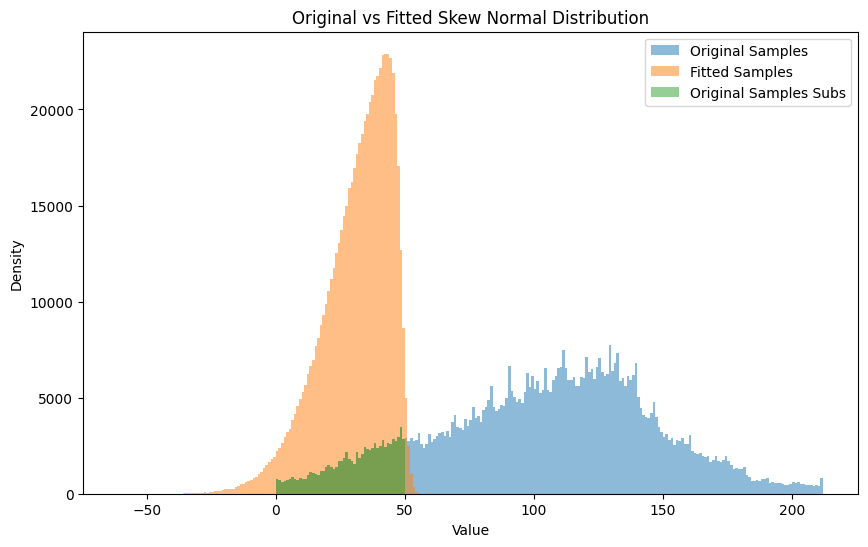

 30%|███       | 3/10 [00:17<00:37,  5.37s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 40%|████      | 4/10 [00:22<00:33,  5.54s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 50%|█████     | 5/10 [00:28<00:27,  5.55s/it]/Users/silaskoemen/Documents/Projects/ForecastPNN/.fpnn_venv/lib/python3.11/site-p

Optimized parameters: mu=48.81, sigma=20.51, alpha=-10.00


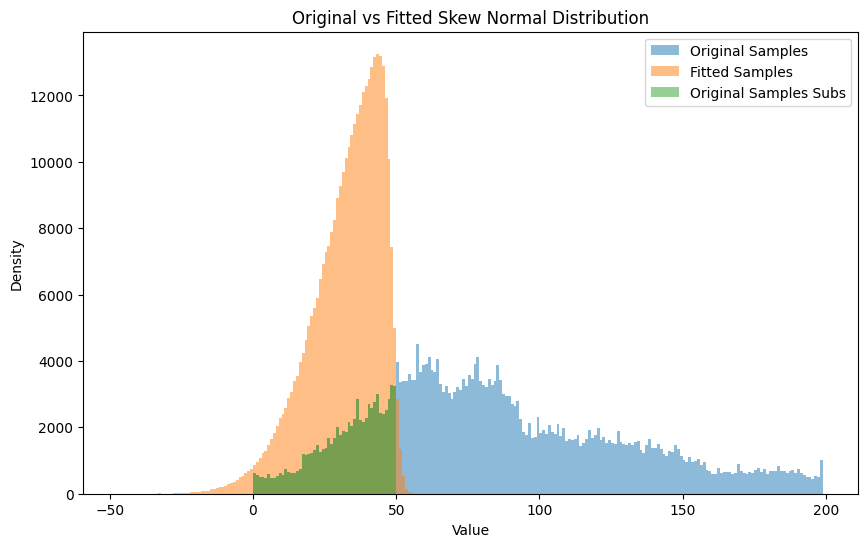

In [70]:
import scipy
from tqdm import tqdm
from scipy.stats import skewnorm

for dr in bounds:
    samples = daily_df.loc[dr, "count"]
    samples_subs = samples.iloc[:50].values
    samples = samples.values
    # Create array of repeated indices based on count values
    samples_array = np.repeat(np.arange(len(samples)), samples)
    samples_subs_array = np.repeat(np.arange(len(samples_subs)), samples_subs)
    mu, sigma, alpha = em_algorithm_skewnormal(samples_subs_array, n_tries=10)
    #mu, sigma, alpha = em_algorithm_skewnormal(samples, n_tries=10)
    print(f"Optimized parameters: mu={mu:.2f}, sigma={sigma:.2f}, alpha={alpha:.2f}")
    print_true_outbreak_vs_fitted_values_subs(samples_array, alpha, mu, sigma, samples_subs_array, density=False)


## Try as Skewnormal-Laplace mixture model, see if EM converges closer, also with less initial obs

In [74]:
def nl_mixture(samples, params):
    pi, alpha, mu_skew, sigma_skew, mu_laplace, b_laplace = params
    # Add penalties for invalid parameter values
    if not (0 <= pi <= 1) or sigma_skew <= 0 or b_laplace <= 0:
        return np.inf
    # Calculate PDFs
    skew_pdf = skewnorm.pdf(samples, alpha, mu_skew, sigma_skew)
    laplace_pdf = (1 / (2 * b_laplace)) * np.exp(-np.abs(samples - mu_laplace) / b_laplace)
    # Mixture PDF
    mixture_pdf = pi * skew_pdf + (1 - pi) * laplace_pdf
    return -np.sum(np.log(mixture_pdf + 1e-10))

def fit_mixture_model(samples, n_tries=10):
    best_params = None
    best_nll = np.inf

    sample_mean = np.mean(samples)
    sample_std = np.std(samples)
    
    # Parameter bounds
    bounds = [
        (0.0, 1.0),  # pi
        (-10, 10),  # alpha
        (0, sample_mean + 5 * sample_std),  # mu_skew
        (0.1 * sample_std, 10 * sample_std),  # sigma_skew
        (0, sample_mean + 5 * sample_std),  # mu_laplace
        (0.1 * sample_std, 10 * sample_std),  # b_laplace
    ]
    
    for _ in tqdm(range(n_tries)):
        x0 = [
            np.random.uniform(0, 1),  # pi
            np.random.uniform(-5, 10),  # alpha
            np.random.normal(sample_mean, sample_std / 2),  # mu_skew
            np.random.uniform(sample_std / 2, sample_std * 2),  # sigma_skew
            np.random.normal(sample_mean, sample_std / 2),  # mu_laplace
            np.random.uniform(sample_std / 2, sample_std * 2),  # b_laplace
        ]
        
        for method in ['Nelder-Mead', 'Powell']:
            result = scipy.optimize.minimize(
                lambda x: nl_mixture(samples, x),
                x0=x0,
                method=method,
                bounds=bounds if method == 'Powell' else None
            )
            if result.success and result.fun < best_nll:
                best_nll = result.fun
                best_params = result.x
                
    if best_params is None:
        raise RuntimeError("Optimization failed to find valid parameters")
    
    return (
        best_params[0],
        best_params[1],
        best_params[2],
        abs(best_params[3]),
        best_params[4],
        abs(best_params[5])
    )
    
    """ return {
        'pi': best_params[0],
        'alpha': best_params[1],
        'mu_skew': best_params[2],
        'sigma_skew': abs(best_params[3]),
        'mu_laplace': best_params[4],
        'b_laplace': abs(best_params[5]),
    } """

In [79]:
from scipy.stats import skewnorm
def print_true_outbreak_vs_fitted_values_mixture_subs(samples, pi, alpha, mu, sigma, mu_laplace, b_laplace, samples_subs = None, density=True):
    num_samples = len(samples)
    samples_sn = skewnorm.rvs(alpha, mu, sigma, size=int(pi*num_samples), random_state=42)
    samples_laplace = np.random.laplace(mu_laplace, b_laplace, size=int((1-pi)*num_samples))
    samples_opt = np.concatenate([samples_sn, samples_laplace])

    # Create integer bins that cover both datasets
    min_val = int(min(min(samples), min(samples_opt)))
    max_val = int(np.ceil(max(max(samples), max(samples_opt))))
    bins = np.arange(min_val, max_val + 1)

    plt.figure(figsize=(10, 6))
    plt.hist(samples, bins=bins, alpha=0.5, label='Original Samples', density=density)
    plt.hist(samples_opt, bins=bins, alpha=0.5, label='Fitted Samples', density=density)
    if samples_subs is not None:
        plt.hist(samples_subs, bins=bins, alpha=0.5, label='Original Samples Subs', density=density)
    plt.legend(loc='upper right')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Original vs Fitted Skew Normal Distribution')
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:40<00:00, 44.12s/it]


Optimized parameters: pi=0.26, alpha=-999.80, mu_skew=78.07, sigma_skew=32.27, mu_laplace=98.01, b_laplace=22.85


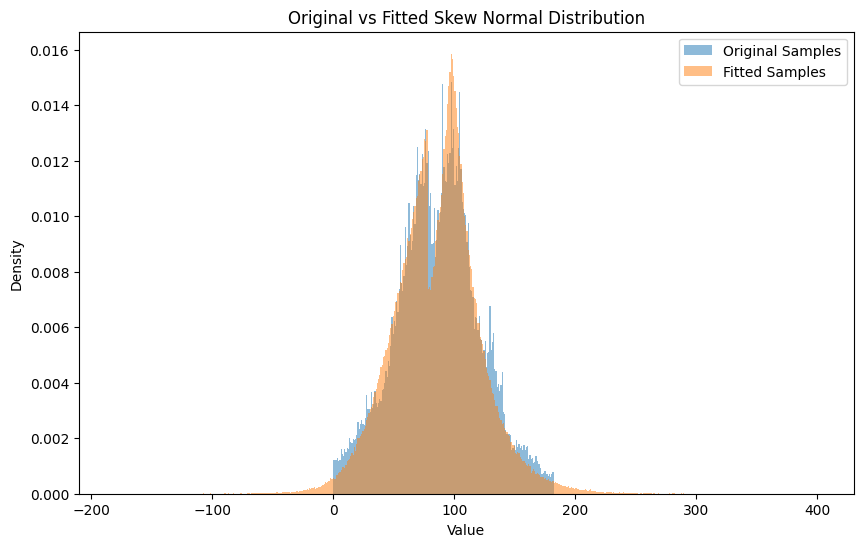

100%|██████████| 5/5 [02:49<00:00, 33.94s/it]


Optimized parameters: pi=0.65, alpha=3.98, mu_skew=65.23, sigma_skew=34.11, mu_laplace=51.00, b_laplace=19.84


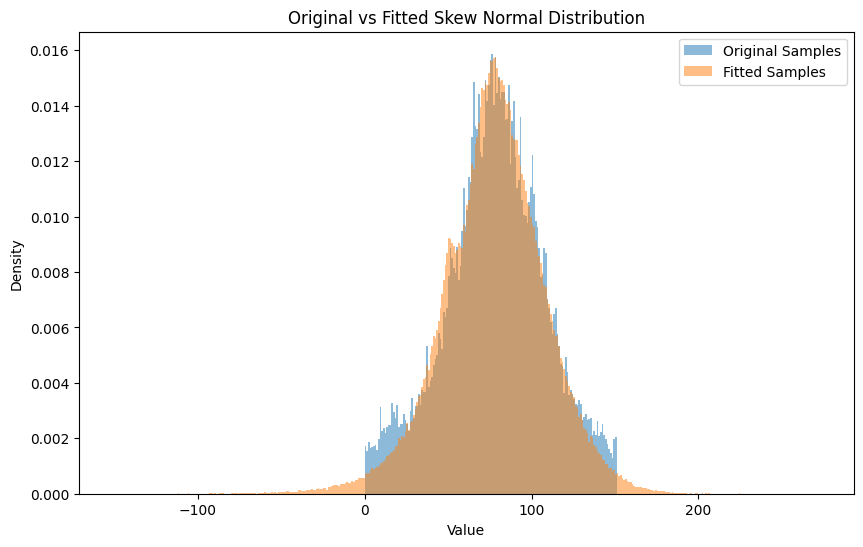

100%|██████████| 5/5 [09:31<00:00, 114.37s/it]


Optimized parameters: pi=0.92, alpha=1.22, mu_skew=54.13, sigma_skew=42.70, mu_laplace=116.00, b_laplace=14.67


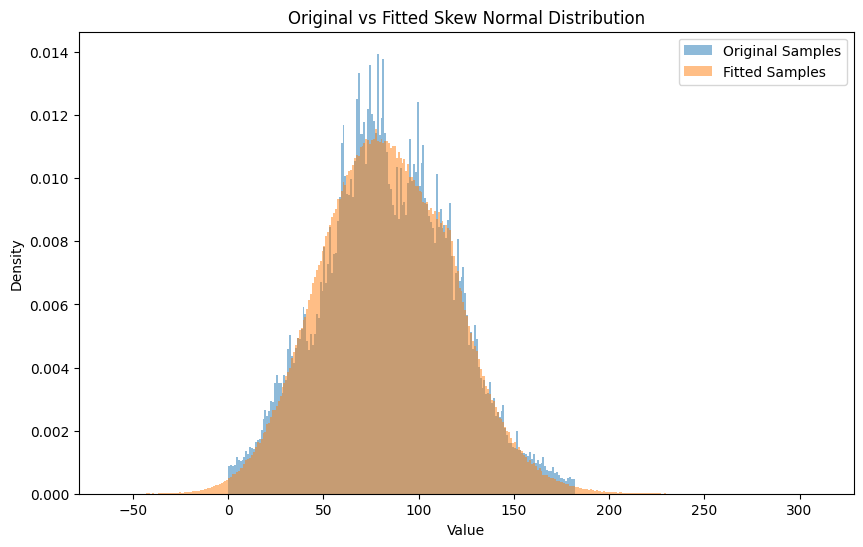

100%|██████████| 5/5 [04:02<00:00, 48.51s/it]


Optimized parameters: pi=1.00, alpha=-1.33, mu_skew=154.30, sigma_skew=56.65, mu_laplace=85.86, b_laplace=32.23


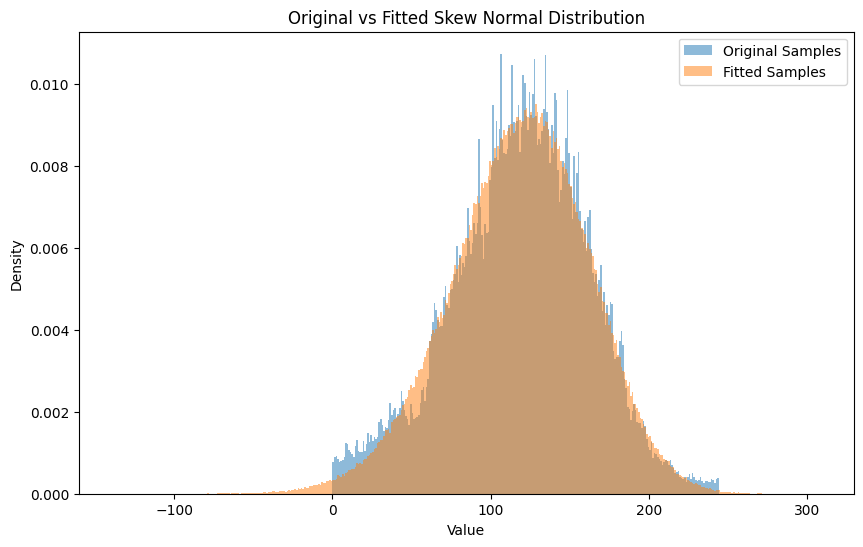

100%|██████████| 5/5 [00:49<00:00,  9.88s/it]


Optimized parameters: pi=0.84, alpha=-0.59, mu_skew=195.55, sigma_skew=70.99, mu_laplace=51.00, b_laplace=23.75


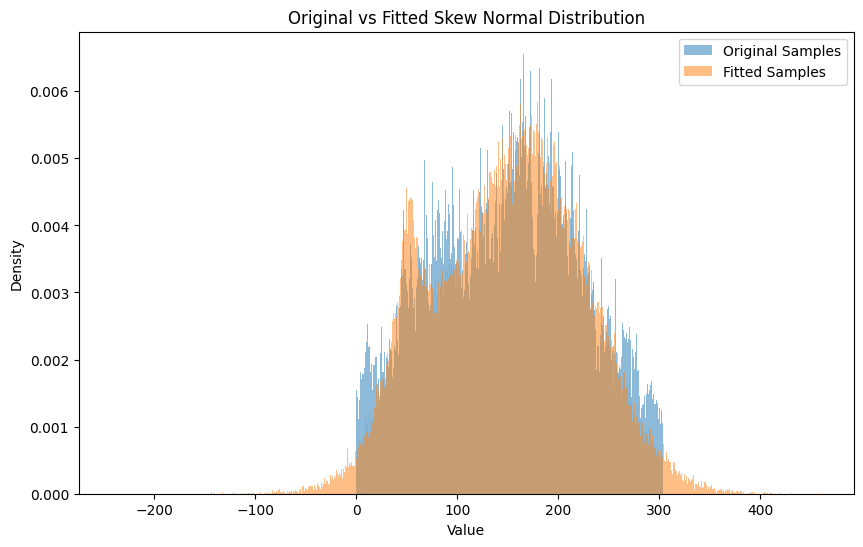

100%|██████████| 5/5 [00:50<00:00, 10.16s/it]


Optimized parameters: pi=0.81, alpha=0.83, mu_skew=162.18, sigma_skew=88.62, mu_laplace=61.00, b_laplace=25.23


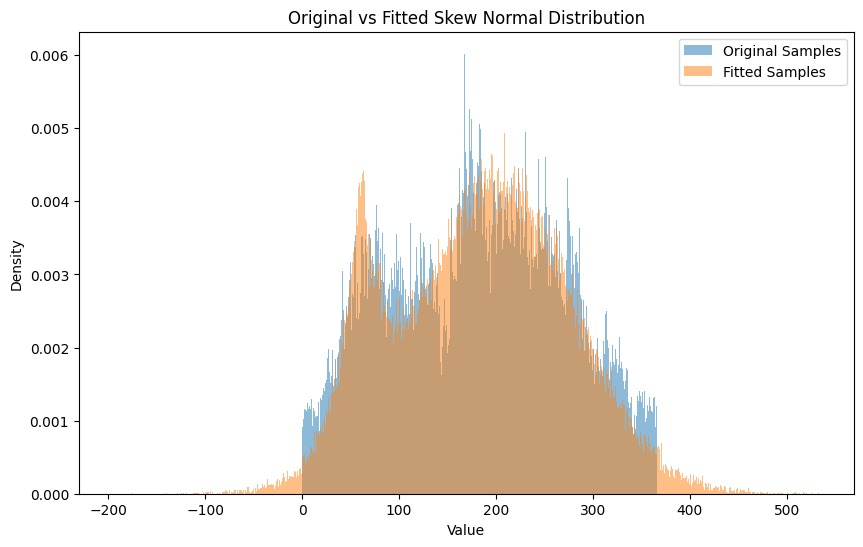

100%|██████████| 5/5 [06:59<00:00, 83.86s/it]


Optimized parameters: pi=0.89, alpha=0.40, mu_skew=100.41, sigma_skew=38.79, mu_laplace=35.00, b_laplace=14.37


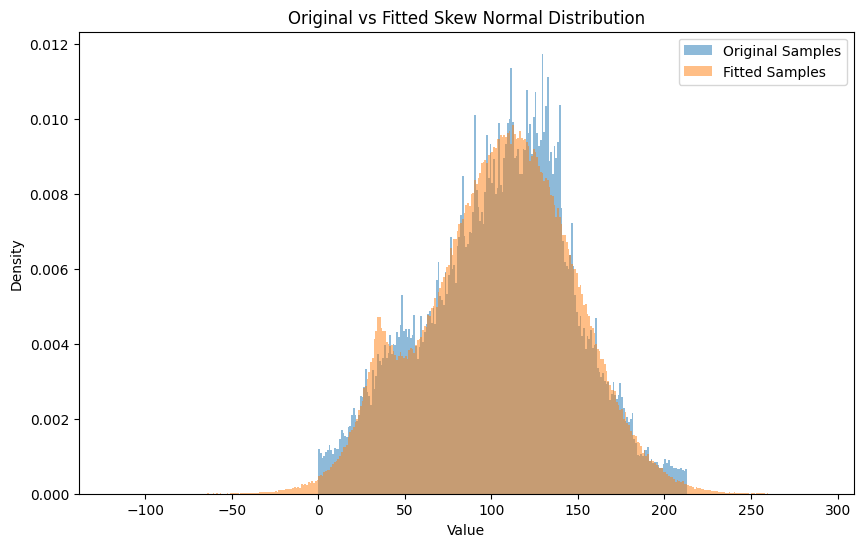

100%|██████████| 5/5 [08:54<00:00, 106.96s/it]


Optimized parameters: pi=0.64, alpha=0.39, mu_skew=86.65, sigma_skew=47.11, mu_laplace=55.90, b_laplace=17.96


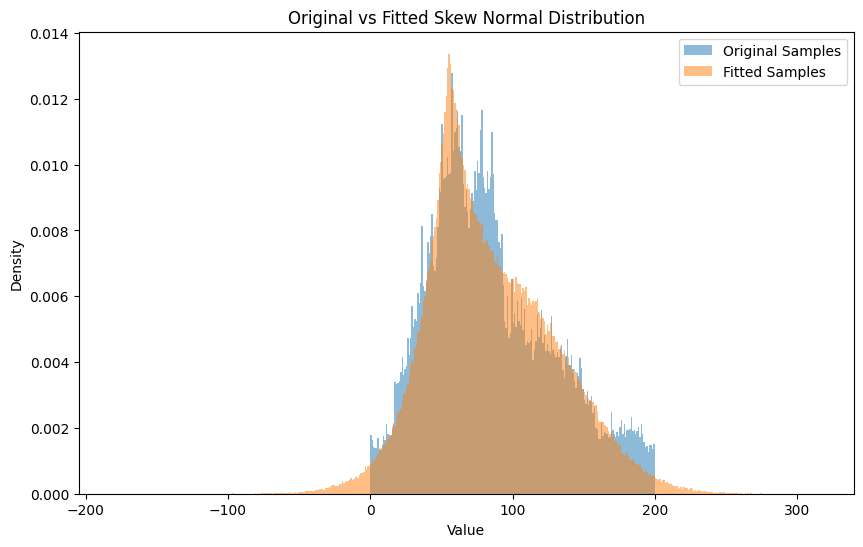

In [81]:
import scipy
from tqdm import tqdm
from scipy.stats import skewnorm

for dr in bounds:
    samples = daily_df.loc[dr, "count"].values
    # Create array of repeated indices based on count values
    samples_array = np.repeat(np.arange(len(samples)), samples)
    pi, alpha, mu, sigma, mu_l, b_l = fit_mixture_model(samples_array, n_tries=5)
    #mu, sigma, alpha = em_algorithm_skewnormal(samples, n_tries=10)
    print(f"Optimized parameters: pi={pi:.2f}, alpha={alpha:.2f}, mu_skew={mu:.2f}, sigma_skew={sigma:.2f}, mu_laplace={mu_l:.2f}, b_laplace={b_l:.2f}")
    print_true_outbreak_vs_fitted_values_mixture_subs(samples_array, pi, alpha, mu, sigma, mu_l, b_l)